In [262]:
'''TODO
Tune hyperparameters with grid search or bayesian optimisation, then do full train and save model weights
Display detailed performance metrics and ensure model is not overfitting
Determine feature importances, and add exogenous features that are likely to be highly correlated (can use tests such as granger causality to assess this)
    Wind Speed: Past wind speeds are highly predictive of future wind production.
    Temperature: Can affect wind patterns and wind production.
    Atmospheric Pressure: Influences wind flow and can be a significant predictor.
    Humidity: Can impact air density and wind speed, affecting wind production.
    Solar Radiation: Can influence thermal gradients, which in turn affect wind patterns
Build a global forecasting model for all regions
Train lightgbm and an svm in the same way
Train meta-model (regularised regression) for stacking on out-of-sample predictions to see if this improves performance
'''

'TODO\nTune hyperparameters with grid search or bayesian optimisation, then do full train and save model weights\nDisplay detailed performance metrics and ensure model is not overfitting\nDetermine feature importances, and add exogenous features that are likely to be highly correlated (can use tests such as granger causality to assess this)\n    Wind Speed: Past wind speeds are highly predictive of future wind production.\n    Temperature: Can affect wind patterns and wind production.\n    Atmospheric Pressure: Influences wind flow and can be a significant predictor.\n    Humidity: Can impact air density and wind speed, affecting wind production.\n    Solar Radiation: Can influence thermal gradients, which in turn affect wind patterns\nBuild a global forecasting model for all regions\nTrain lightgbm and an svm in the same way\nTrain meta-model (regularised regression) for stacking on out-of-sample predictions to see if this improves performance\n'

In [263]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

from import_dataset import prepare_data
from constants import COUNTRY_CODES
import add_features

In [264]:
#df, df_countries = prepare_data()

from os.path import join
import pandas as pd
from prepare_data import prepare_data

df, df_country = prepare_data()

In [265]:
print(df.shape)
print(df_country.shape)

(262968, 255)
(262968, 29)


In [266]:
print(df_country)

                      AT   BE   BG   CH  CY   CZ   DE   DK   EE   ES  ...  \
Hour                                                                  ...   
1986-01-01 00:00:00  0.0  0.0  0.0  0.0   0  0.0  0.0  0.0  0.0  0.0  ...   
1986-01-01 01:00:00  0.0  0.0  0.0  0.0   0  0.0  0.0  0.0  0.0  0.0  ...   
1986-01-01 02:00:00  0.0  0.0  0.0  0.0   0  0.0  0.0  0.0  0.0  0.0  ...   
1986-01-01 03:00:00  0.0  0.0  0.0  0.0   0  0.0  0.0  0.0  0.0  0.0  ...   
1986-01-01 04:00:00  0.0  0.0  0.0  0.0   0  0.0  0.0  0.0  0.0  0.0  ...   
...                  ...  ...  ...  ...  ..  ...  ...  ...  ...  ...  ...   
2015-12-31 19:00:00  0.0  0.0  0.0  0.0   0  0.0  0.0  0.0  0.0  0.0  ...   
2015-12-31 20:00:00  0.0  0.0  0.0  0.0   0  0.0  0.0  0.0  0.0  0.0  ...   
2015-12-31 21:00:00  0.0  0.0  0.0  0.0   0  0.0  0.0  0.0  0.0  0.0  ...   
2015-12-31 22:00:00  0.0  0.0  0.0  0.0   0  0.0  0.0  0.0  0.0  0.0  ...   
2015-12-31 23:00:00  0.0  0.0  0.0  0.0   0  0.0  0.0  0.0  0.0  0.0  ...   

In [183]:
df = add_features.add_calendar_features(df)
df_country = add_features.add_calendar_features(df_country)

# Encode country codes numerically. Currently using a crude numbering system that is not at all related to
# geographic proximity. TODO: Switch to lat long values
df_country['']

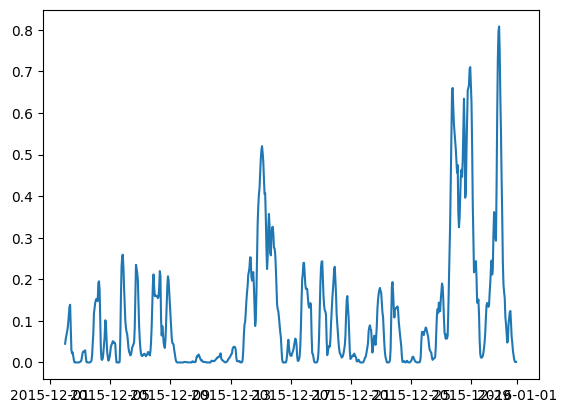

In [184]:
df_last_month = df[-(24*30):]
plt.plot(df_last_month.index, df_last_month['ES24'])

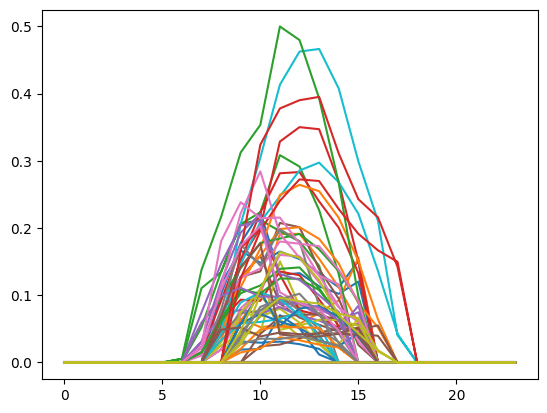

In [185]:
# First day of data
df_first_day_countries = df_country[['Hour'] + COUNTRY_CODES].iloc[:48, :]
df_first_day_countries = df_first_day_countries.set_index('Hour')
plt.plot(df_first_day_countries.index, df_first_day_countries)

In [214]:
# To start with I'll create a simple local model to forecast only the hour-ahead wind energy potential values for Belgium

# Get the last four years of data for belgium
n = 30
df_be_last_n_years = df_country.loc[df_country['Year'].isin(range(2015-n, 2015)), 'FR']

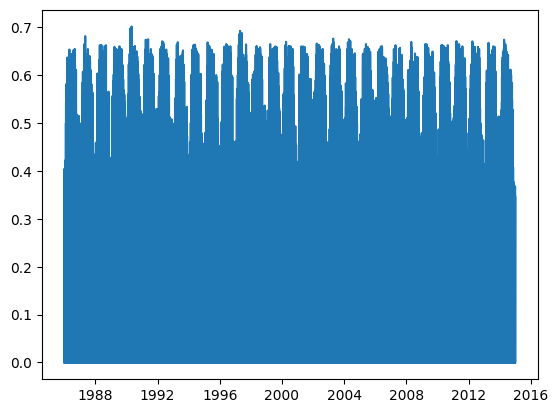

In [215]:
# Plotting the daily data over the two year period suggests there is daily, monthly and annual seasonality
plt.plot(df_be_last_n_years.index, df_be_last_n_years)

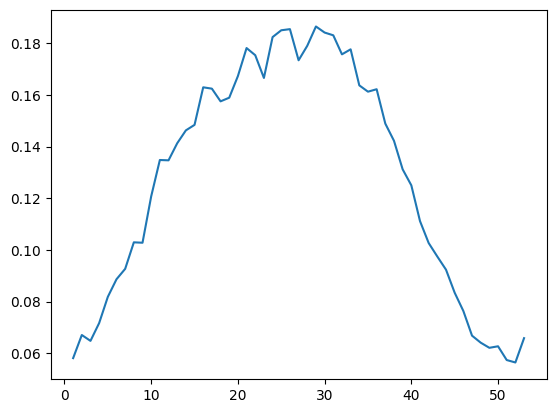

In [216]:
# Plot the weekly totals  for each week of the year over the last four years
df_weekly_totals = df_be_last_n_years.groupby(df_be_last_n_years.index.isocalendar().week).mean()
plt.plot(df_weekly_totals.index, df_weekly_totals)

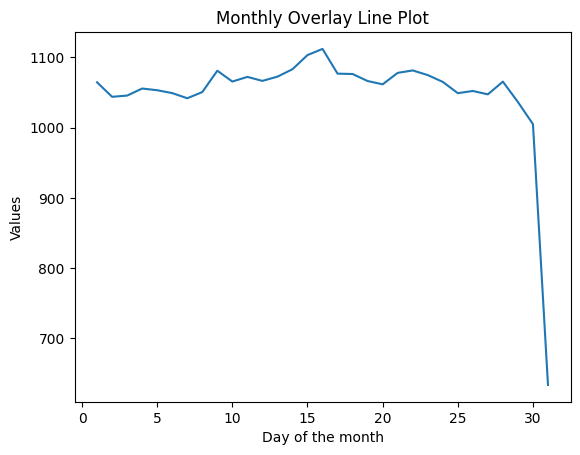

In [217]:
# Let't plot the daily values for each month overlayed to get a clearer picture of monthly seasonality
df_be_last_n_years_daily_tot = df_be_last_n_years.groupby(df_be_last_n_years.index.day).sum()
plt.plot(df_be_last_n_years_daily_tot.index, df_be_last_n_years_daily_tot)
plt.xlabel('Day of the month')
plt.ylabel('Values')
plt.title('Monthly Overlay Line Plot')
plt.show()

In [218]:
# It appears as though the monthly seasonality is less pronounced,
# with the drop on day 31 likely due to the shorter months causing the total to drop

In [ ]:
# Calculate the autocorrelation and plot a correlelogram for each hourly lag. This is unlikely to
# give us much useful information as the series is not stationary

# Calculate lag-n autocorrelation
lags = 24 * 7  # Number of hourly lags (for the past week)

'''autocorr_values = [df_be_last_n_years.autocorr(lag=lag) for lag in range(lags)]

print(autocorr_values)

# Create a correlogram
plt.figure(figsize=(8, 6))
plt.stem(range(lags), autocorr_values)#, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Hourly autocorrelation for the Past Week')
plt.grid(True)
plt.show()'''

# Plot ACF
sm.graphics.tsa.plot_acf(df_be_last_n_years.values.squeeze(), lags=48*3)
plt.show()

# Plot PACF
sm.graphics.tsa.plot_pacf(df_be_last_n_years.values.squeeze(), lags=48*3, method="ywm")
plt.show()


In [221]:
from add_features import add_time_lags, add_calendar_features, add_aggregations
# Time delay embedding

# Prepare the training set by adding lags, other temporal data and eventually some exogeneous featured
# to help the model learn more effectively. It seems like a few days' worth of hourly lags should
# suffice, whilst also keeping the number of features at a manageable level

df = add_time_lags(df_be_last_n_years)
df = add_calendar_features(df, num_fourier_terms=2, normalise=True)
df = add_aggregations(df)


In [227]:
# Save cleaned dataset to csv
df.to_csv('./data/belgium_cleaned_30_years.csv')

In [223]:
# Drop first rows with missing lag values
df = df.dropna()

In [224]:
# Split up the dataset. Just do simple 80:20 split for now

X = df.drop(columns=['Wind_Energy_Potential'])
y = df['Wind_Energy_Potential']

train_size = int(len(y) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train.astype(float)
X_test.astype(float)
y_train.astype(float)
y_test.astype(float)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

'''
# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train and test model for this split
    ...
'''



(203328, 61)
(50832, 61)
(203328,)
(50832,)


'\n# Create a TimeSeriesSplit object\ntscv = TimeSeriesSplit(n_splits=5)\n\nfor train_index, test_index in tscv.split(X):\n    \n    X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n    y_train, y_test = y.iloc[train_index], y.iloc[test_index]\n    \n    # Train and test model for this split\n    ...\n'

In [225]:
'''# train a simple fully-connected neural network
from sklearn.neural_network import MLPRegressor

# the sklearn multilayer perceptron uses mse as the loss function and this can't be changed
reg = MLPRegressor(hidden_layer_sizes=(5, 5, 5), solver='adam', alpha=1e-5, random_state=1)
reg.fit(X_train, y_train)

# After training, you can predict labels for new samples
y_pred = reg.predict(X_test)

# Convert to series with same index as y_test
y_pred = pd.Series(y_pred, index=y_test.index)

residuals = y_pred - y_test
'''

"# train a simple fully-connected neural network\nfrom sklearn.neural_network import MLPRegressor\n\n# the sklearn multilayer perceptron uses mse as the loss function and this can't be changed\nreg = MLPRegressor(hidden_layer_sizes=(5, 5, 5), solver='adam', alpha=1e-5, random_state=1)\nreg.fit(X_train, y_train)\n\n# After training, you can predict labels for new samples\ny_pred = reg.predict(X_test)\n\n# Convert to series with same index as y_test\ny_pred = pd.Series(y_pred, index=y_test.index)\n\nresiduals = y_pred - y_test\n"

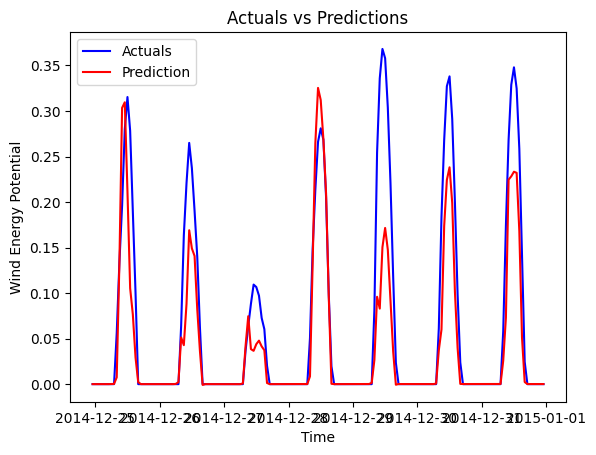

In [226]:
def plot_actuals_vs_predictions(y_pred: np.ndarray, y_test: np.ndarray, last_n_days: int = 7) -> None:
    
    # Only want the last 7 days
    end_date = df.index.max()
    start_date = end_date - pd.Timedelta(days=last_n_days)

    # Plot the target predictions against the actuals for the test set for the last month
    plt.plot(y_test[start_date:end_date], label='Actuals', color='blue')
    plt.plot(y_pred[start_date:end_date], label='Prediction', color='red')

    plt.xlabel('Time')
    plt.ylabel('Wind Energy Potential')
    plt.title('Actuals vs Predictions')
    plt.legend()

    plt.show()

plot_actuals_vs_predictions(y_pred, y_test)

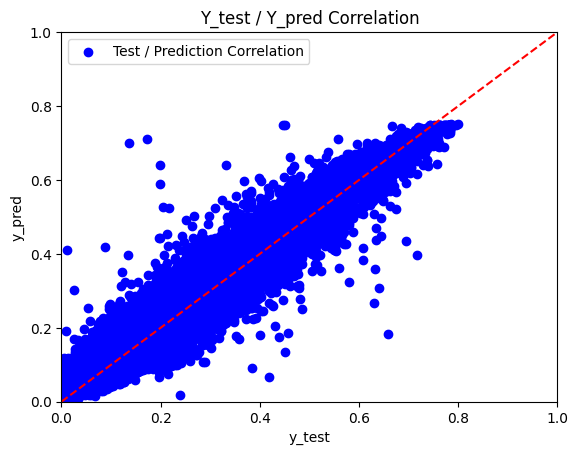

In [ ]:
def plot_prediction_actuals_correlation(y_pred: np.ndarray, y_test: np.ndarray) -> None:

    plt.scatter(y_test, y_pred, color='blue', label='Test / Prediction Correlation')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')

    # Set axes to start at 0
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.title('Y_test / Y_pred Correlation')
    plt.legend()

plot_prediction_actuals_correlation(y_pred, y_test)

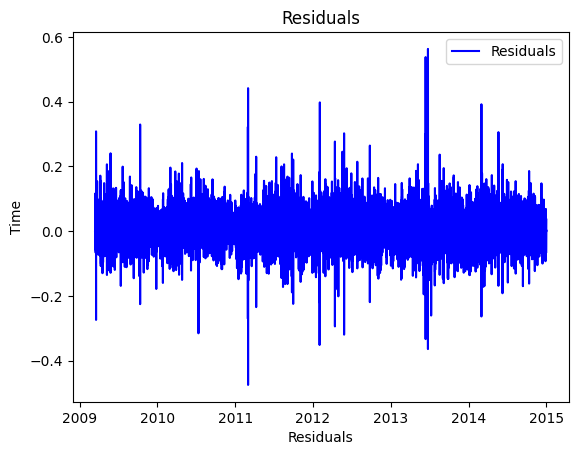

In [ ]:
def plot_residuals(residuals: np.ndarray) -> None:
    # Plot the residuals
    # Plot the target predictions against the actuals for the test set for the last month
    plt.plot(residuals, label='Residuals', color='blue')

    plt.xlabel('Residuals')
    plt.ylabel('Time')
    plt.title('Residuals')
    plt.legend()

    plt.show()

plot_residuals(residuals)

In [239]:
# Train a lightgbm model (quicker than xgboost and accepts categorical features without one-hot encoding)
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

param_space = {
    'num_leaves': (20, 50),
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'feature_fraction': (0.7, 1.0, 'uniform'),
    'bagging_fraction': (0.7, 1.0, 'uniform'),
    'max_depth': (3, 10),
    'min_child_samples': (5, 30)
}

# Set up bayesian optimisation
opt = BayesSearchCV(
    estimator=lgb.LGBMRegressor(objective='regression', metric='mean_squared_error', boosting_type='gbdt'),
    search_spaces=param_space,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42
)

opt.fit(X_train, y_train)

best_estimator = opt.best_estimator_

y_pred = best_estimator.predict(X_test, num_iteration=best_estimator.best_iteration)

mse = mean_squared_error(y_test, y_pred)

print(f"Best parameters found: {opt.best_params_}")
print(f"Mean Squared Error on test set: {mse}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

'bst = lgb.train(\n    params,\n    train_data,\n    num_round,\n    valid_sets=[test_data],\n    callbacks=[\n        lgb.early_stopping(stopping_rounds=3),\n    ])\n\ny_pred: np.ndarray = bst.predict(X_test, num_iteration=bst.best_iteration)\n\n# Convert predictions to a pandas Series with the same index as y_test\ny_pred = pd.Series(y_pred, index=y_test.index)\n\n# Calculate residuals\nresiduals = y_pred - y_test'

In [253]:
# Retrain with the best params for more iterations
best_params = {'boosting_type': 'gbdt', 'bagging_fraction': 0.7629144166677786, 'feature_fraction': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 25, 'num_leaves': 50}

num_iters = 1000

estimator = lgb.train(
    best_params,
    train_data,
    num_iters,
    valid_sets=[test_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=3),
    ])

y_pred: np.ndarray = estimator.predict(X_test, num_iteration=estimator.best_iteration)

# Convert predictions to a pandas Series with the same index as y_test
y_pred = pd.Series(y_pred, index=y_test.index)

# Calculate residuals
residuals = y_pred - y_test

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13472
[LightGBM] [Info] Number of data points in the train set: 203328, number of used features: 61
[LightGBM] [Info] Start training from score 0.127597
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[92]	valid_0's l2: 0.000144512


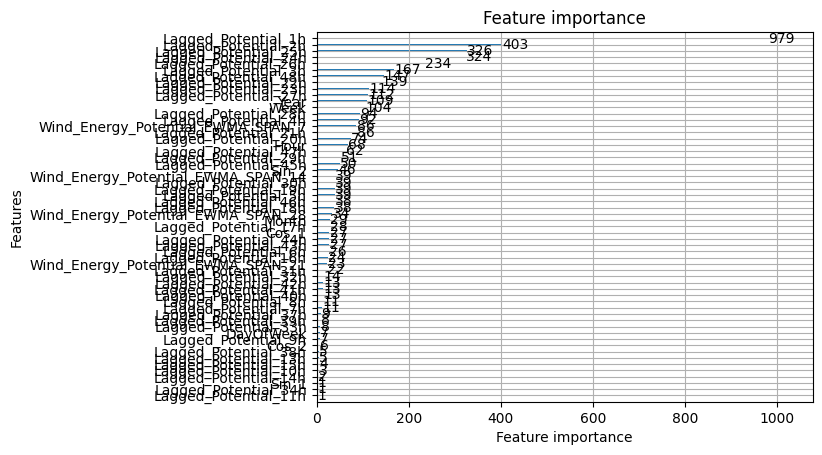

In [259]:
lgb.plot_importance(estimator, importance_type='split')
plt.show()

In [254]:
import metrics

# Also calculate in-sample predictions for metric calculation
y_train_pred = estimator.predict(X_train, num_iteration=estimator.best_iteration)

# Display performance metrics and charts
train_mse = metrics.mse(y_train_pred, y_train.values)
test_mse = metrics.mse(y_pred, y_test.values)

bias = metrics.bias(y_train_pred, y_train)
variance = metrics.variance(y_pred)

print(f'Train MSE: {train_mse:.4f}. Test MSE: {test_mse:.4f}')
print(f'Bias: {bias:.4f}. Variance: {variance:.4f}')

Train MSE: 0.0002. Test MSE: 0.0001
Bias: 0.0000. Variance: 0.0317


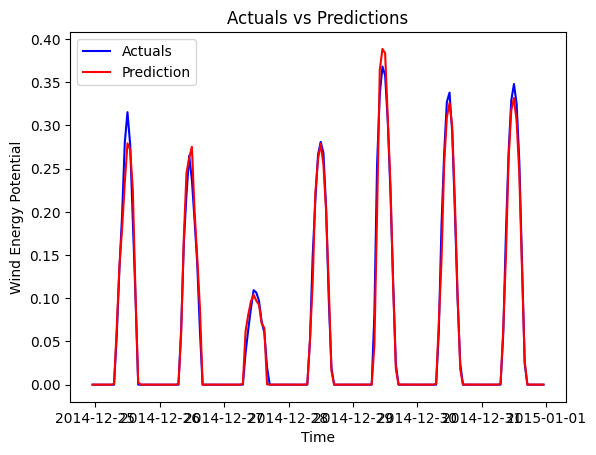

In [261]:
plot_actuals_vs_predictions(y_pred, y_test, last_n_days=7)

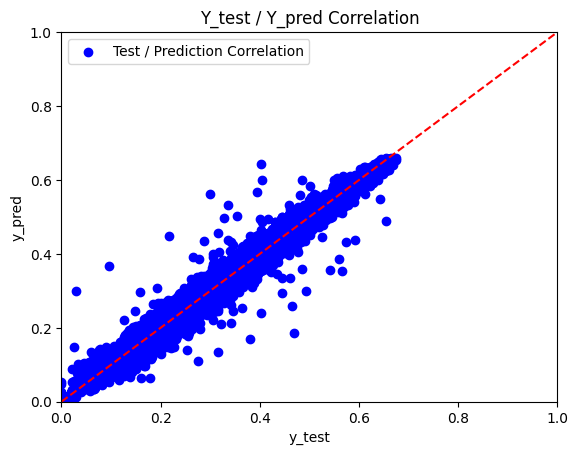

In [255]:
plot_prediction_actuals_correlation(y_pred, y_test)

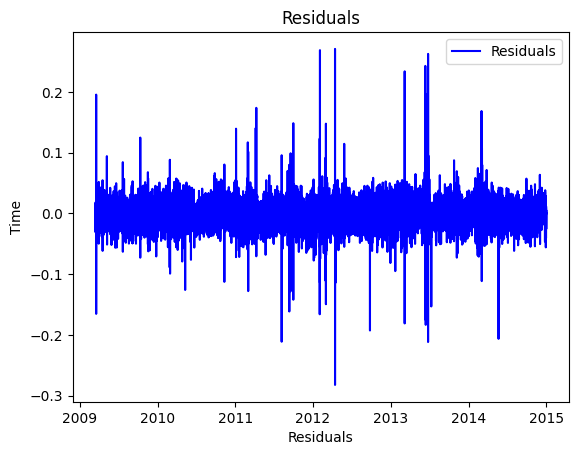

In [256]:
plot_residuals(residuals)